In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import zscore, median_abs_deviation

/tmp/ipykernel_16089/217056624.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
item_categories = pd.read_csv('data/item_categories.csv')
items = pd.read_csv('data/items.csv')
sales = pd.read_csv('data/sales_train.csv')
shops = pd.read_csv('data/shops.csv')
test = pd.read_csv('data/test.csv')

In [3]:
print(item_categories.shape)
item_categories.head()

(84, 2)


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [4]:
print(items.shape)
items.head()

(22170, 3)


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [5]:
print(shops.shape)
shops.head()
# weird values in the beginning (eps. considering the fact that they're doubled in a normal format)


(60, 2)


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [6]:
print(sales.shape)
sales.head()

(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [7]:
template = 'Column {:15} -> {:4} nans'
for col in sales.columns:
    print(template.format(col, sales[col].isna().sum()))

Column date            ->    0 nans
Column date_block_num  ->    0 nans
Column shop_id         ->    0 nans
Column item_id         ->    0 nans
Column item_price      ->    0 nans
Column item_cnt_day    ->    0 nans


In [47]:
item_categories.columns

Index(['item_category_name', 'item_category_id'], dtype='object')

In [44]:
# see if there're any items with negative price

sales[sales['item_price']<=0].merge(items, on='item_id', how='inner')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
0,2013-05-15,4,32,2973,-1.0,1.0,"DmC Devil May Cry [PS3, русские субтитры]",19


In [8]:
# check if some sales reference a shop that is not listed in shops 

#using left join so we necessarily include all the sales
sales_items = sales.merge(items, on='item_id', how='left')
sales_items[sales_items['item_name'].isna()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id


In [9]:
# check if some sales reference an item that is not listed in items

sales_shops = sales.merge(shops, on='shop_id', how='left')
sales_items[sales_shops['shop_name'].isna()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id


In [37]:
# check on shops and items that are present in test, but not listed in train

test[test.merge(shops, on='shop_id', how='left')['shop_name'].isna()]

,ID,shop_id,item_id


In [35]:
test[test.merge(items, on='item_id', how='left')['item_name'].isna()]

,ID,shop_id,item_id


In [42]:
# items with unknown category

items[items.merge(item_categories, on='item_category_id', how='left')['item_category_name'].isna()]

,item_name,item_id,item_category_id


In [10]:
pattern = r"^[А-Яа-яA-Za-z][А-Яа-яA-Za-z0-9\s\"\.,\-\(\)]*$"
shops[~shops['shop_name'].str.match(pattern)]

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
10,Жуковский ул. Чкалова 39м?,10
11,Жуковский ул. Чкалова 39м²,11


In [11]:
#item names can include pretty much anything so I'm checking only the beginnning

pattern = r"^[А-Яа-яA-Za-zЁё0-9].*$"
items[~items['item_name'].str.match(pattern)]

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,***ЧАЙ С МУССОЛИНИ D,8,40
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


In [12]:
sales.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [13]:
sales['date'] = pd.to_datetime(sales['date'], format='%d.%m.%Y')

In [14]:
def histplots(df : pd.DataFrame, column_names: list[str], bins : int = 200, title = None):
    plt.figure(figsize = (20, 5))
    if title: plt.suptitle(title)
    sns.set_palette(sns.color_palette('pastel'))
    for index, col in enumerate(column_names):
        plt.subplot(1, len(column_names), index+1)
        sns.histplot(df[col], bins=bins)
    plt.show()

In [15]:
def boxplots(df: pd.DataFrame, column_names: list[str], title=None):
    plt.figure(figsize=(20, 5))
    if title:
        plt.suptitle(title)
    sns.set_palette(sns.color_palette('pastel'))
    for index, col in enumerate(column_names):
        plt.subplot(1, len(column_names), index+1)
        sns.boxplot(df[col])
    plt.show()

In [16]:
# no shops with too few sales, so that's good

sales['shop_id'].value_counts().sort_values()

shop_id
36       306
11       499
20      1792
8       3412
9       3751
40      4257
33      5027
1       5678
34      5752
23      6963
32      7947
0       9857
39     13440
49     15849
13     17824
10     21397
48     21612
17     22950
3      25532
2      25991
12     34694
55     34769
45     35891
14     36979
5      38179
4      38242
43     39282
44     39530
37     39638
41     41967
59     42108
52     43502
51     44433
22     45434
38     46013
29     49225
30     50860
16     52734
53     52921
24     53032
18     53227
26     53910
47     56695
7      58076
21     58133
35     58445
15     59511
19     63911
50     65173
46     66321
56     69573
58     71441
6      82663
27    105366
42    109253
57    117428
28    142234
54    143480
25    186104
31    235636
Name: count, dtype: int64

In [17]:
num_cols = ['item_id', 'item_price', 'item_cnt_day']

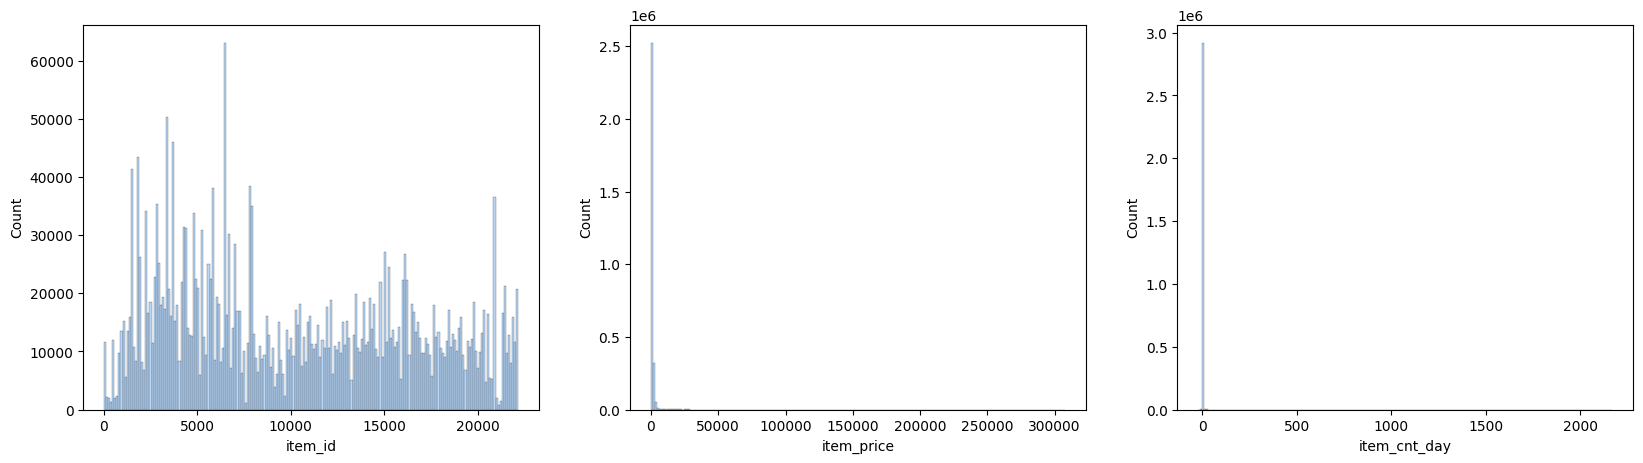

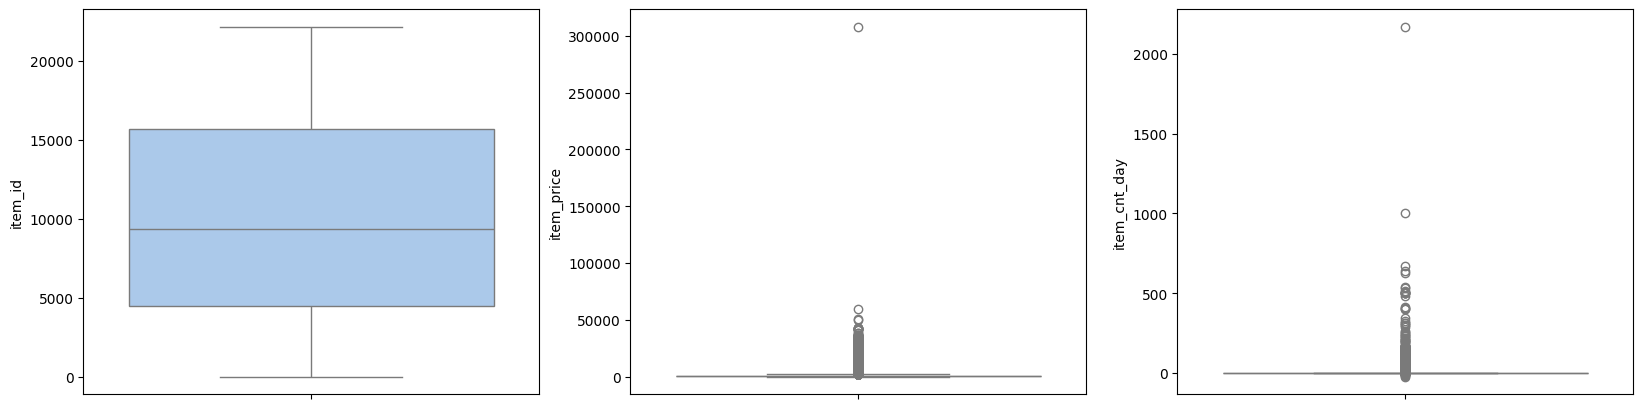

In [18]:
histplots(sales, num_cols)
boxplots(sales, num_cols)

Can see some outliers in `item_price` and `item_cnt_day`, which have to be cleared later

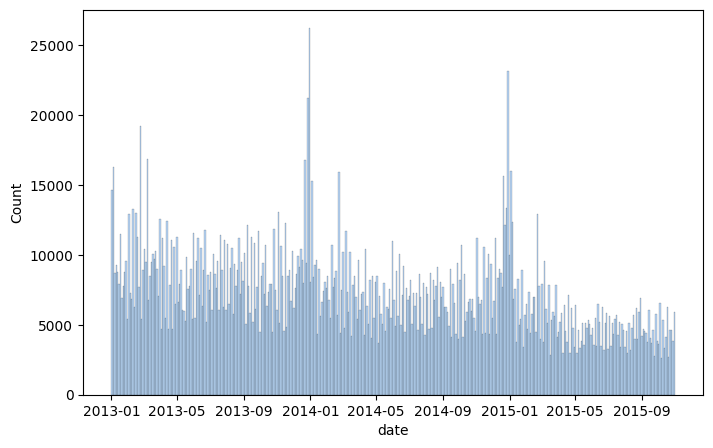

In [19]:
plt.figure(figsize=(8, 5))
sns.histplot(sales['date'], bins=400)
plt.show()

In [20]:
sales[sales['item_cnt_day']<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,2013-01-05,0,25,2552,899.0,-1.0
148,2013-01-23,0,25,2321,999.0,-1.0
175,2013-01-07,0,25,2199,1449.0,-1.0
807,2013-01-02,0,25,2330,599.0,-1.0
1041,2013-01-13,0,25,5034,1989.0,-1.0
...,...,...,...,...,...,...
2934243,2015-10-26,33,25,3917,449.0,-1.0
2934462,2015-10-18,33,25,4896,6398.0,-1.0
2935263,2015-10-05,33,25,10039,249.0,-1.0
2935643,2015-10-16,33,25,7893,2990.0,-1.0


See if those values have some binding to dates

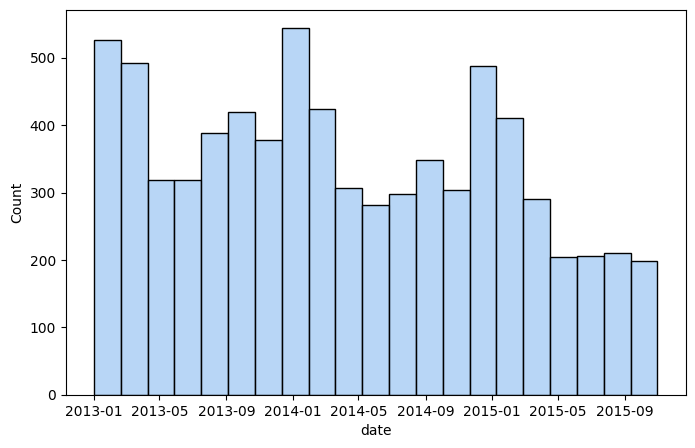

In [21]:
plt.figure(figsize=(8, 5))
sns.histplot(sales[sales['item_cnt_day'] < 0]['date'])
plt.show()

Those spike around new year time as well, so it's probaby connected to sells growth, which means they should not be considered errors

In [22]:
mask = sales['item_cnt_day'] > 500
sales[mask].merge(items, on='item_id', how='inner')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
0,2014-04-22,15,27,8057,1200.000000,502.0,iTunes 1500 руб.,32
1,2014-06-28,17,25,20949,5.000000,501.0,Фирменный пакет майка 1С Интерес белый (34*42)...,71
2,2014-10-02,21,12,9242,1500.000000,512.0,"Билет ""ИгроМир 2014"" (на один день (отдельно -...",8
3,2014-10-09,21,55,19437,899.000000,508.0,"Средиземье: Тени Мордора [PC, Цифровая версия]",31
4,2015-01-15,24,12,20949,4.000000,1000.0,Фирменный пакет майка 1С Интерес белый (34*42)...,71
5,2015-04-14,27,12,3731,1904.548077,624.0,"Grand Theft Auto V [PC, русские субтитры]",30
6,2015-05-19,28,12,11373,155.192950,539.0,Доставка до пункта выдачи (Boxberry),9
7,2015-09-29,32,55,9249,1500.000000,533.0,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",8
8,2015-09-30,32,55,9249,1702.825746,637.0,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",8
9,2015-09-30,32,12,9248,1692.526158,669.0,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [...",80


In [48]:
with pd.option_context('display.max_colwidth', 400):
    display(items[items['item_name'].str.contains("Билет")])

,item_name,item_id,item_category_id
9240,"Билет ""День Бухгалтерии""",9240,73
9241,"Билет ""ИгроМир 2014"" (на один день (отдельно - 3 октября 2014))",9241,8
9242,"Билет ""ИгроМир 2014"" (на один день (отдельно - 4, 5 октября 2014))",9242,8
9243,"Билет ""ИгроМир 2014"" - семейный до 4-х человек вкл. (на один день (отдельно - 3, 4, 5 октября 2014))",9243,8
9244,"Билет ""ИгроМир 2015"" - 2 октября 2015 (сайт) [Цифровая версия]",9244,80
9245,"Билет ""ИгроМир 2015"" - 2 октября 2015 (сайт) УПР [Цифровая версия]",9245,8
9246,"Билет ""ИгроМир 2015"" - 2 октября 2015 [Цифровая версия]",9246,80
9247,"Билет ""ИгроМир 2015"" - 2 октября 2015 УПР [Цифровая версия]",9247,8
9248,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [Цифровая версия]",9248,80
9249,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) УПР [Цифровая версия]",9249,8


In [24]:
mask = sales['item_price'] > 50000
sales[mask].merge(items, on='item_id', how='inner')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
0,2013-09-17,8,12,11365,59200.0,1.0,Доставка (EMS),9
1,2013-12-13,11,12,6066,307980.0,1.0,Radmin 3 - 522 лиц.,75
2,2014-03-20,14,25,13199,50999.0,1.0,Коллекционные шахматы (Властелин Колец),69


In [25]:
items.merge(sales['item_id'].value_counts(), on='item_id', how='inner').sort_values('count', ascending=False)

,item_name,item_id,item_category_id,count
20602,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,71,31340
5717,Playstation Store пополнение бумажника: Карта ...,5822,35,9408
17418,Прием денежных средств для 1С-Онлайн,17717,79,9067
2749,"Diablo III [PC, Jewel, русская версия]",2808,30,7479
4097,Kaspersky Internet Security Multi-Device Russi...,4181,75,6853
...,...,...,...,...
10551,ДВЕНАДЦАТЬ СТУЛЬЕВ (М.ЗАХАРОВ) (1-2 СЕРИЯ) (rem),10752,40,1
10552,ДВЕНАДЦАТЬ СТУЛЬЕВ (М.ЗАХАРОВ) (3-4 СЕРИЯ) (rem),10753,40,1
10597,ДЕВУШКА С ТАТУИРОВКОЙ ДРАКОНА,10799,40,1
10633,ДЕЛО ГАСТРОНОМА № 1,10835,40,1


### Removing outliers


The formulas for mod. z-score are found [here](https://www.ibm.com/docs/en/cognos-analytics/11.1.0?topic=terms-modified-z-score)

In [26]:
def modified_zscore(data : pd.Series):
    # probably there's an error in calculations somewhere, cause it literally equals infinity on some values
    median = data.median()
    mad = median_abs_deviation(data)
    if mad == 0:
        return pd.Series((data-median)/(1.253314*mad))
    return pd.Series((data-median)/(1.486*mad))

In [27]:
def remove_outliers(df : pd.DataFrame, column_names : list[str], criteria : callable = zscore, threshold : float = 3):
    for col in column_names:
        mask = abs(criteria(df[col])) > threshold
        df = df.drop(df[mask].index)
    return df

##### Testing various methods of outlier detection

Here I'm trying regular z-score and modified z-score to see which one has better results

In [28]:
sales_copy = sales.copy()
before = sales_copy.shape[0]
sales_copy = remove_outliers(sales_copy, num_cols)
after = sales_copy.shape[0]

template = '{:2.2%} of data removed as outliers'

print(template.format(1 - (after/before)))

1.38% of data removed as outliers


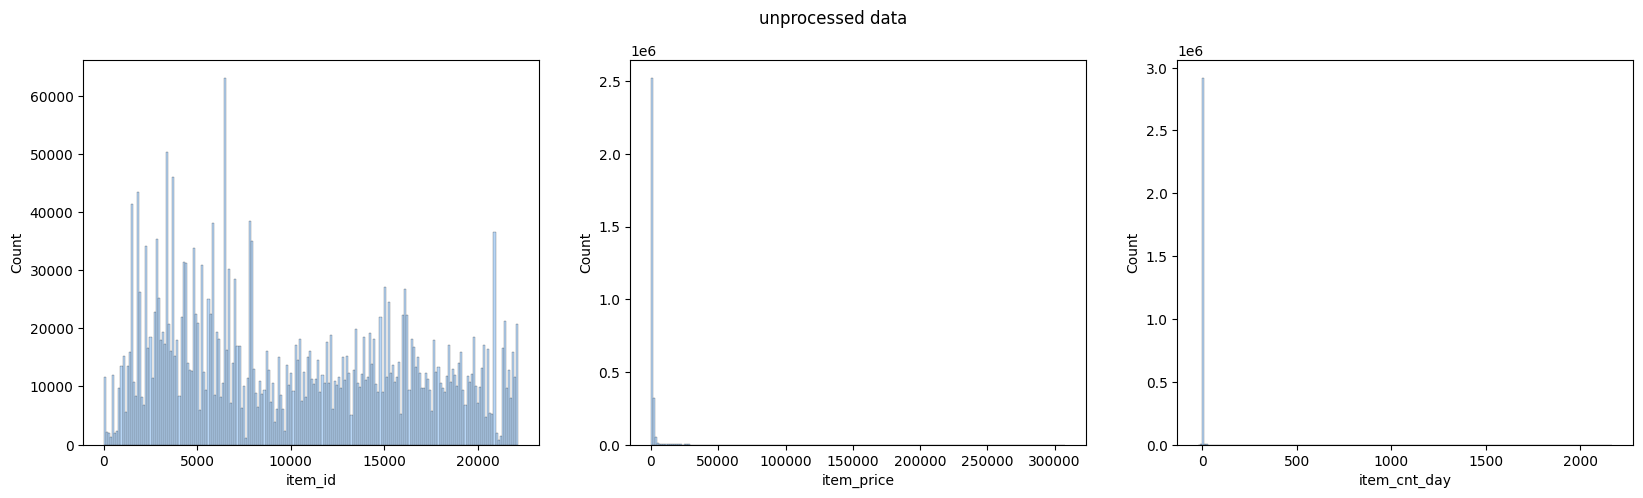

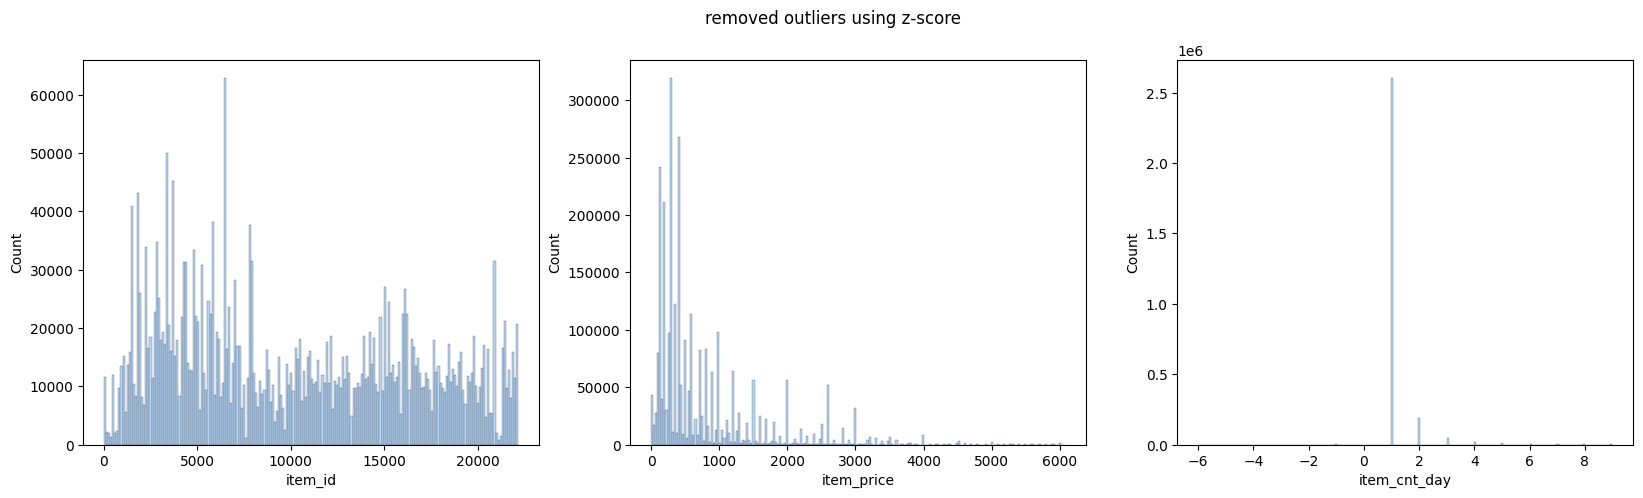

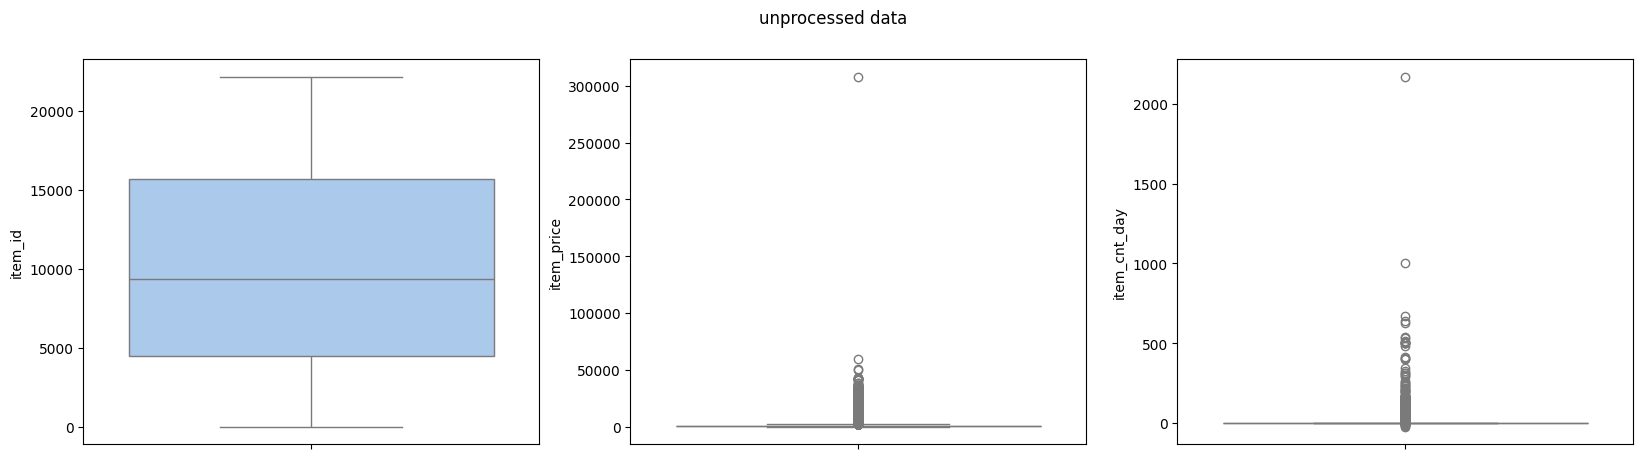

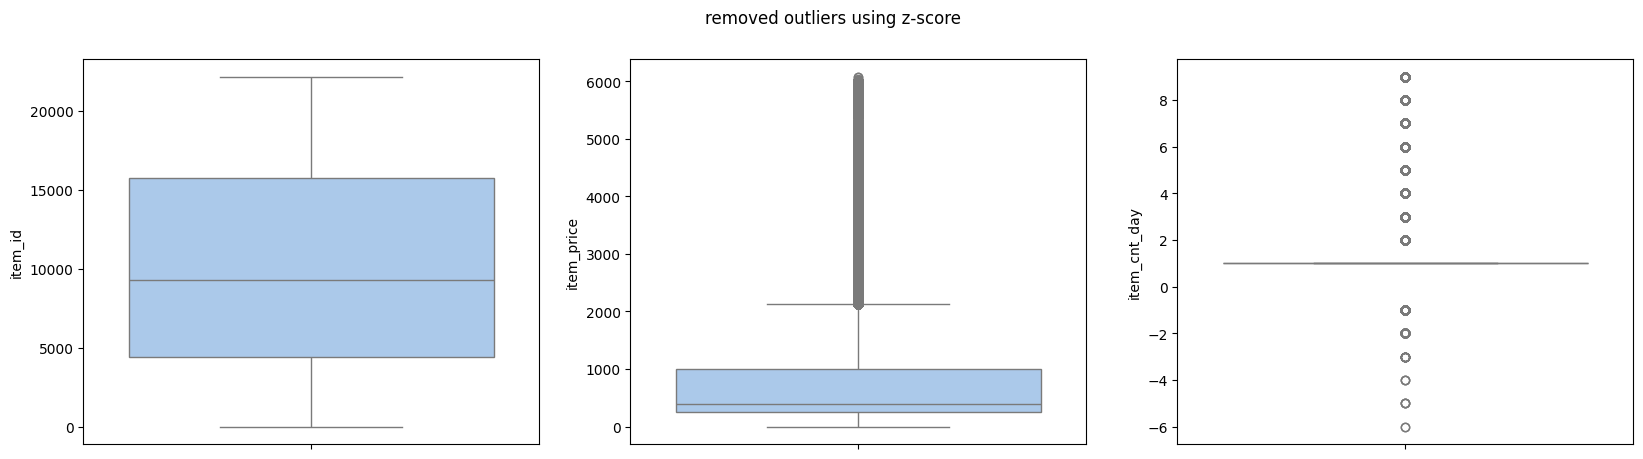

In [29]:
histplots(sales, num_cols, title="unprocessed data")
histplots(sales_copy, num_cols, title="removed outliers using z-score")
boxplots(sales, num_cols, title="unprocessed data")
boxplots(sales_copy, num_cols, title="removed outliers using z-score")

In [30]:
sales_copy['item_cnt_day'].value_counts()

item_cnt_day
 1.0    2604403
 2.0     191951
 3.0      46805
 4.0      19443
 5.0      10347
-1.0       7067
 6.0       6257
 7.0       3998
 8.0       2880
 9.0       2150
-2.0         76
-3.0         13
-5.0          4
-4.0          3
-6.0          2
Name: count, dtype: int64

In [31]:
sales_copy_mod = sales.copy()
before = sales_copy_mod.shape[0]
sales_copy_mod = remove_outliers(sales_copy_mod, num_cols, criteria=modified_zscore, threshold=5)
after = sales_copy_mod.shape[0]

template = '{:2.2%} of data removed as outliers'

print(template.format(1 - (after/before)))

17.33% of data removed as outliers


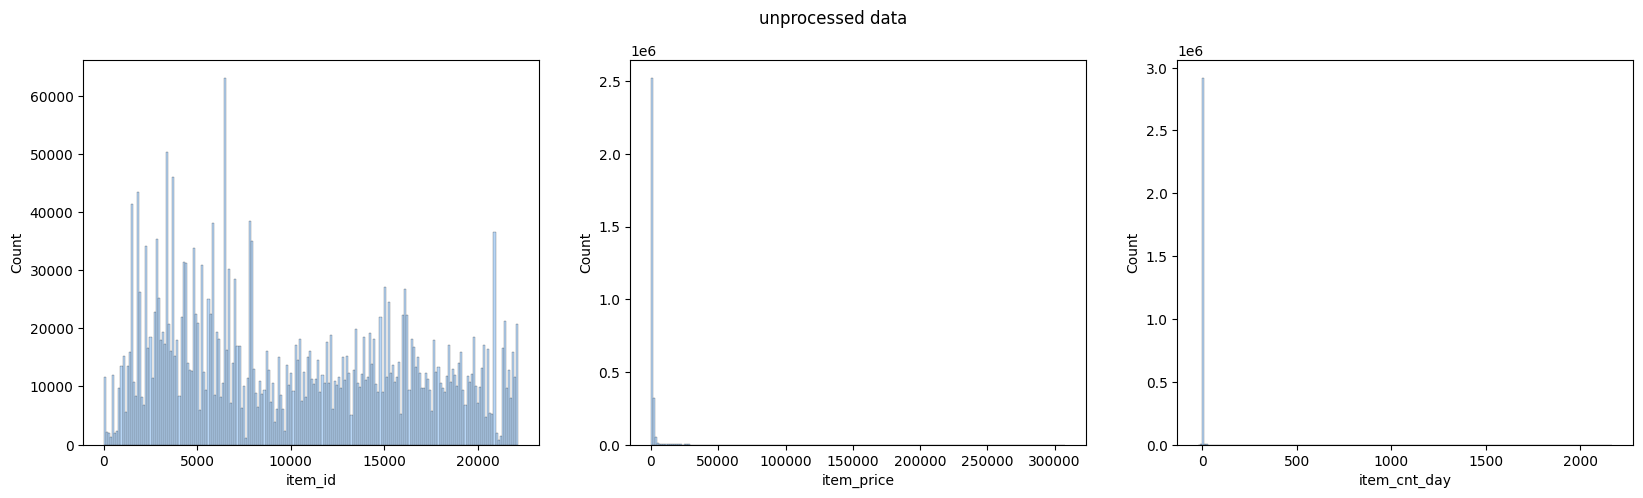

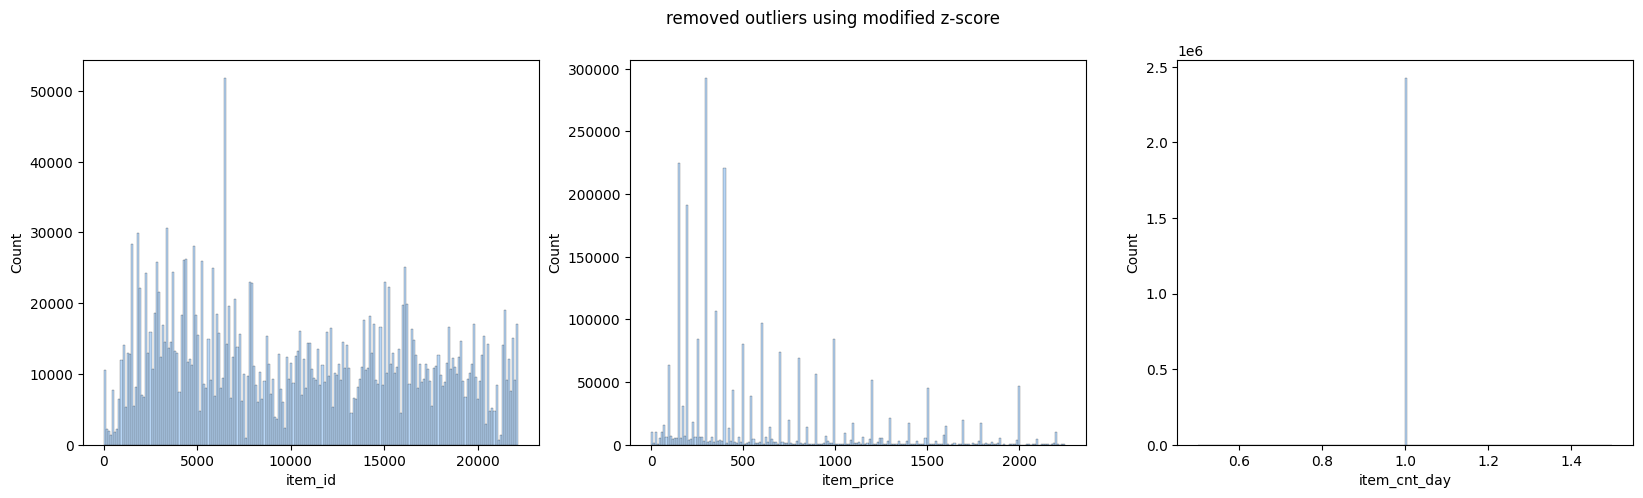

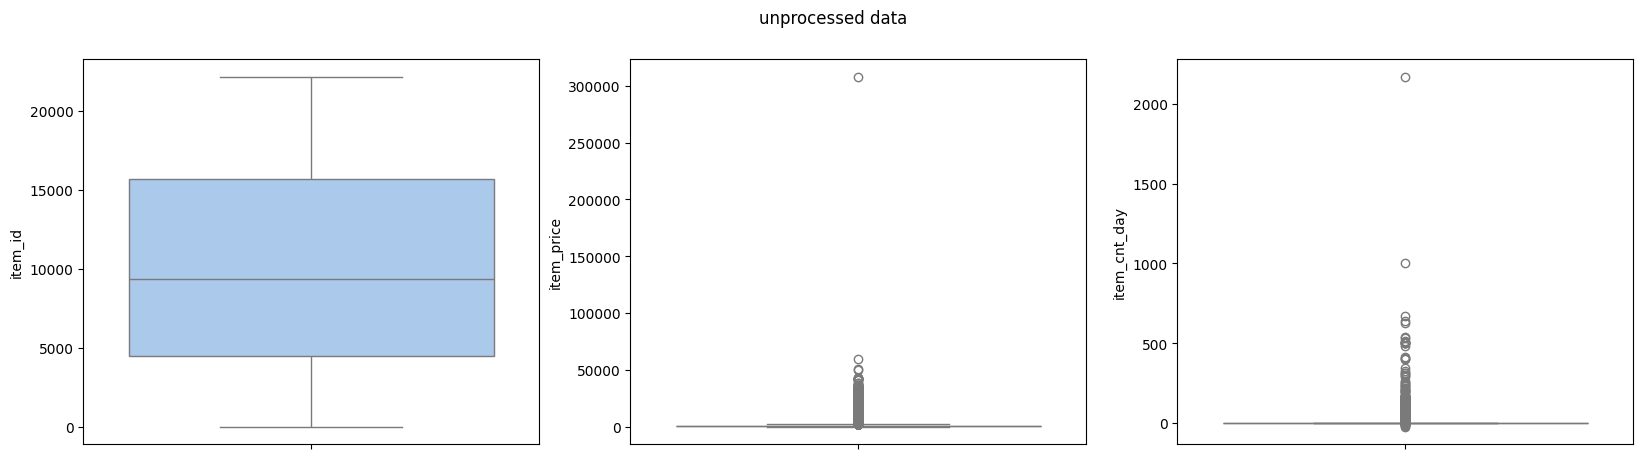

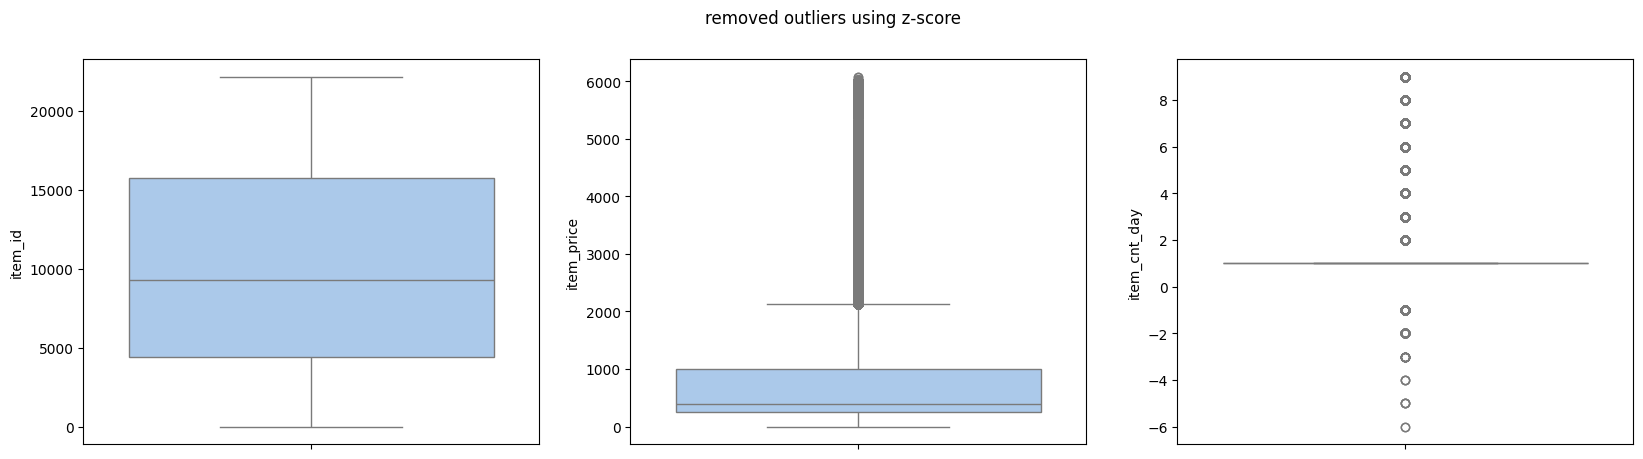

In [32]:
histplots(sales, num_cols, title="unprocessed data")
histplots(sales_copy_mod, num_cols, title="removed outliers using modified z-score")
boxplots(sales, num_cols, title="unprocessed data")
boxplots(sales_copy, num_cols, title="removed outliers using z-score")

We lose too much data by using the modified z-score (probably due to my own mistake which I haven't found yet), so we'll use the regular z-score for now.

Conclusion:
- Data does not contain unresolved references
- There are some outliers in data, which will have to be cleared 
- Different tables do not conflict with each other, however, in `items` and `shops` there are some duplicate values, references to which will have to be resolved later
- There's one item sold with negative price, so it should be removed
- Different kinds of tickets to the same event should *maybe* be merged into one
